# **Model Selection to estimate Agents**

For each station, find a good model to predict the individual pollutants.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Models
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import xgboost as xgb

# Metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

from utils import *

datasets_folder = './datasets'
figsize = (20,4)
verbosity = 0

metrics = [root_mean_squared_error, r2_score, mean_absolute_error, huber]

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Import

In [2]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [3]:
station_data = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 35


In [ ]:
station_data['GIARDINI MARGHERITA']['NO2'].columns

Index(['Agent_value', 'Traffic_value', 'TAVG', 'PREC', 'RHAVG', 'RAD',
       'W_SCAL_INT', 'W_VEC_DIR', 'LEAFW', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'month_rbf_1', 'month_rbf_2', 'month_rbf_3', 'month_rbf_4',
       'month_rbf_5', 'month_rbf_6', 'month_rbf_7', 'month_rbf_8',
       'month_rbf_9', 'month_rbf_10', 'month_rbf_11', 'month_rbf_12'],
      dtype='object')

In [ ]:
station_data['GIARDINI MARGHERITA']['PM2.5'].columns

Index(['Agent_value', 'Traffic_0-3', 'Traffic_4-7', 'Traffic_8-11',
       'Traffic_12-15', 'Traffic_16-19', 'Traffic_20-0', 'TAVG', 'PREC',
       'RHAVG', 'RAD', 'W_SCAL_INT', 'W_VEC_DIR', 'LEAFW', 'TAVG_MAX',
       'TAVG_MIN', 'RHAVG_MAX', 'RHAVG_MIN', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'month_rbf_1', 'month_rbf_2', 'month_rbf_3', 'month_rbf_4',
       'month_rbf_5', 'month_rbf_6', 'month_rbf_7', 'month_rbf_8',
       'month_rbf_9', 'month_rbf_10', 'month_rbf_11', 'month_rbf_12'],
      dtype='object')

As we can see for daily data we have the correct encoding of the hourly values for the traffic and the weather (like 'TAVG_MAX','TAVG_MIN', 'RHAVG_MAX', 'RHAVG_MIN') and the data encoding.

## **Training Data**

In [4]:
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'
RANDOM_STATE = 42

In [5]:
training_sets = {}
test_sets = {}

for station in stations:
    training_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        training_sets[station][agent] = {}
        test_sets[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent], train_split_date, y=target)

        training_sets[station][agent]['x'] = x_train
        training_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = x_test
        test_sets[station][agent]['y'] = y_test

In [ ]:
training_sets['GIARDINI MARGHERITA']['NO2']['x'].head(1) # example

,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,-0.548779,-1.741683,-0.13755,1.320229,-0.663642,-1.41615,0.046922,-0.464033,0.0,1.0,...,0.000335,1.522998e-08,1.266417e-14,1.928750e-22,5.380186e-32,1.928750e-22,1.266417e-14,1.522998e-08,0.000335,0.135335


## **Hourly agents**

As a test, let's see if the same agent-model achieves similar performances on all the stations.

In [6]:
hour_models = {} # contains tuples: (ModelGenerator, model_params:dict, training_params:dict|None, sequences:bool)

#### **Random Forest Regressor**

In [ ]:
rfr_params = {
    'n_estimators':300,
    'max_depth':20,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE,
}

hour_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

##### *Testing...*

In [ ]:
station = 'PORTA SAN FELICE'
agent = 'NO2'

rfr_model = RandomForestRegressor(**rfr_params)
rfr_model.fit(training_sets[station][agent]['x'], training_sets[station][agent]['y'])
rfr_pred = rfr_model.predict(test_sets[station][agent]['x'])
rfr_pred_df = pd.DataFrame(rfr_pred, index=test_sets[station][agent]['y'].index)

/home/davide/Desktop/AI/AIII/project/AII-project/aiii-venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


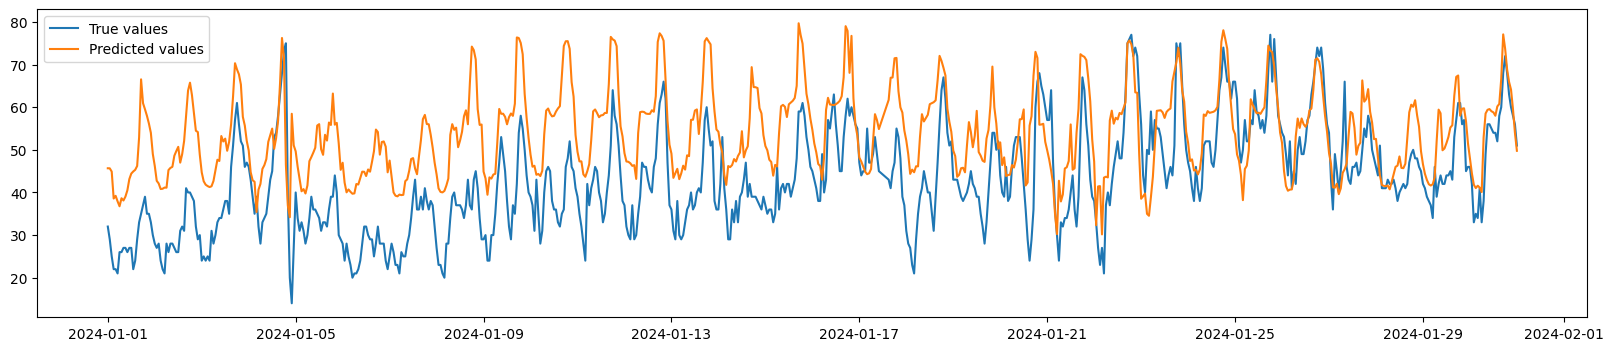

root_mean_squared_error: 19.775551788928556
r2_score: -0.9450164955317244
mean_absolute_error: 16.89963258816707
huber: 3.359981060028076


In [ ]:
start = datetime(2024,1,1)
end = datetime(2024,1,31)

plt.figure(figsize=figsize)
plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index>=start)&(test_sets[station][agent]['y'].index<=end)], label='True values')
plt.plot(rfr_pred_df[(rfr_pred_df.index>=start)&(rfr_pred_df.index<=end)], label='Predicted values')
plt.legend()
plt.show()

rfr_scores={}
for m in metrics:
    rfr_score = m(test_sets[station][agent]['y'],rfr_pred_df)
    print(f'{m.__name__}: {rfr_score}')
    rfr_scores[m.__name__] = rfr_score

In [ ]:
18.900530735030173
r2_score: -0.776719957000005
mean_absolute_error: 15.995552701298633

#### **LSTM**

In [7]:
from tensorflow.keras.layers import Masking

In [8]:
def buid_lstm_model(time_steps, n_features, use_mask, optimizer='adam', loss='mean_absolute_error'):
    model = None
    if use_mask:
        model = Sequential([
            Masking(mask_value=-999.0, input_shape=(time_steps, n_features)),
            LSTM(128, return_sequences=False),
            # Dropout(0.2),
            # LSTM(50, return_sequences=False),
            # Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1)
        ])
    else:
        model = Sequential([
            LSTM(128, return_sequences=False, input_shape=(time_steps, n_features)),
            # Dropout(0.2),
            # LSTM(50, return_sequences=False),
            # Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1)
        ])
    
    model.compile(optimizer=optimizer, loss=loss)
    
    return model

lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'use_mask':True,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error'
}

lstm_train_params = {
    'epochs':20,
    'batch_size':64,
}

hour_models['LSTM-masked'] = (buid_lstm_model, lstm_params, lstm_train_params, True)

In [9]:
lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'use_mask':False,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error'
}

hour_models['LSTM'] = (buid_lstm_model, lstm_params, lstm_train_params, True)

In [10]:
lstm_params2 = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'use_mask':False,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

lstm_train_params2 = {
    'epochs':10,
    'batch_size':32,
}

hour_models['LSTM-old'] = (buid_lstm_model, lstm_params2, lstm_train_params2, True)

In [11]:
lstm_params2 = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'use_mask':True,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

lstm_train_params2 = {
    'epochs':10,
    'batch_size':32,
}

hour_models['LSTM-old-masked'] = (buid_lstm_model, lstm_params2, lstm_train_params2, True)

In [ ]:
def buid_lstm_2_model(time_steps, n_features, use_mask, optimizer='adam', loss='mean_squared_error'):
    model = None
    # PS: non so come si propaga la maschera... gpt dice che outputta degli 0 in quegli spot...
    # non so come il layer successivo poi li usa???
    if use_mask:
        model = Sequential([
            Masking(mask_value=-999.0, input_shape=(time_steps, n_features)),
            LSTM(64, return_sequences=True),
            LSTM(32, return_sequences=False),
            Dense(16, activation='relu'),
            Dense(1)
        ])
    else: 
        model = Sequential([
            LSTM(64, return_sequences=True, input_shape=(time_steps, n_features)),
            LSTM(32, return_sequences=False),
            Dense(16, activation='relu'),
            Dense(1)
        ])

    model.compile(optimizer=optimizer, loss=loss)

    return model

lstm_2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'use_mask':False,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error'
}

lstm_2_train_params = {
    'epochs':20,
    'batch_size':32,
}

hour_models['LSTM_2'] = (buid_lstm_2_model, lstm_2_params, lstm_2_train_params, True)


In [13]:

lstm_2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'use_mask':True,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error'
}

hour_models['LSTM_2-masked'] = (buid_lstm_2_model, lstm_2_params, lstm_2_train_params, True)

##### *Testing...*

**NOTE:** when creating sequences, there might be missing values. If that happens, you could end up with sequences containing non-consecutive data.

In [ ]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

ts = lstm_params['time_steps']
lstm_x_train, lstm_y_train = create_sequences(training_sets[station][agent]['x'], training_sets[station][agent]['y'], ts, use_mask=False)

lstm_x_test = pd.concat([training_sets[station][agent]['x'].iloc[-ts+1:], test_sets[station][agent]['x']]) # to also compute the first days we need time_steps more days
lstm_x_test, lstm_y_test = create_sequences(lstm_x_test, test_sets[station][agent]['y'], ts, use_mask=False)

In [17]:
tf.keras.backend.clear_session()  # Reset TensorFlow state
set_random_seed(42) 
lstm_model = buid_lstm_model(**lstm_params)
lstm_model.fit(
    lstm_x_train,
    lstm_y_train,
    **lstm_train_params
)
lstm_pred = lstm_model.predict(lstm_x_test)
lstm_pred_df = pd.DataFrame(lstm_pred, index=lstm_y_test.index)


Epoch 1/20
668/668 [==============================] - 5s 3ms/step - loss: 6.4959
Epoch 2/20
668/668 [==============================] - 2s 3ms/step - loss: 5.3761
Epoch 3/20
668/668 [==============================] - 2s 3ms/step - loss: 5.2511
Epoch 4/20
668/668 [==============================] - 2s 3ms/step - loss: 5.1915
Epoch 5/20
668/668 [==============================] - 2s 3ms/step - loss: 5.1348
Epoch 6/20
668/668 [==============================] - 2s 3ms/step - loss: 5.0900
Epoch 7/20
668/668 [==============================] - 2s 3ms/step - loss: 5.0431
Epoch 8/20
668/668 [==============================] - 2s 3ms/step - loss: 4.9814
Epoch 9/20
668/668 [==============================] - 2s 3ms/step - loss: 4.9419
Epoch 10/20
668/668 [==============================] - 2s 3ms/step - loss: 4.8499
Epoch 11/20
668/668 [==============================] - 2s 3ms/step - loss: 4.7666
Epoch 12/20
668/668 [==============================] - 2s 3ms/step - loss: 4.6839
Epoch 13/20
668/668 [====

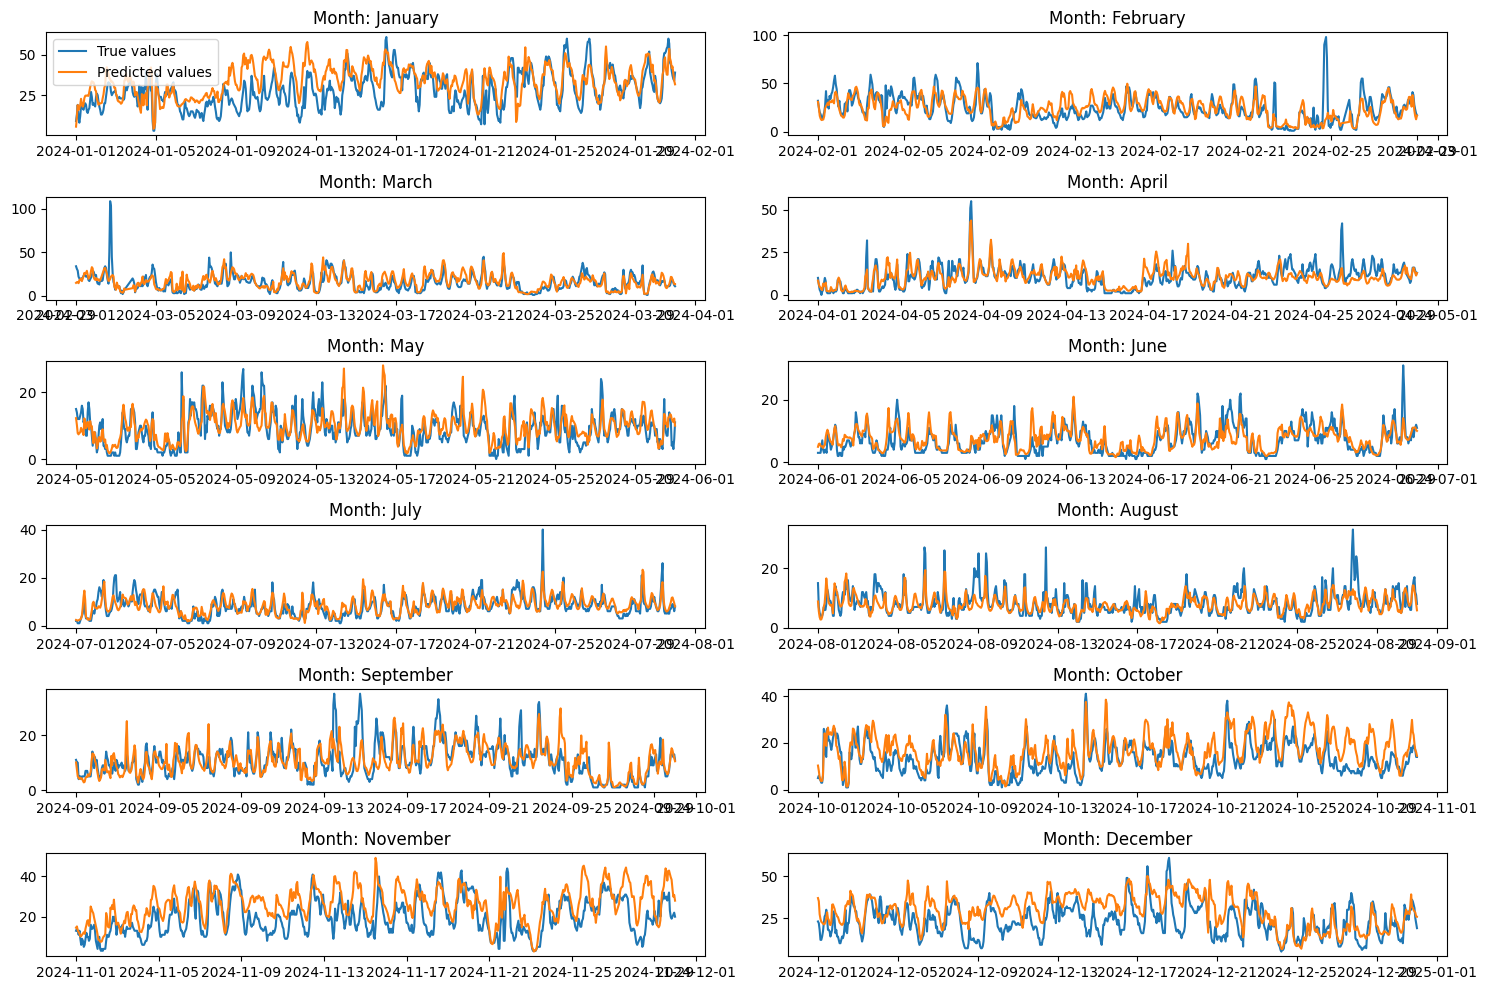

root_mean_squared_error: 7.02989112822942 (7.953116534847338)
r2_score: 0.5576846287723488 (0.5847334097263513)
mean_absolute_error: 4.740561764520725 (5.279064677960013)
huber: 0.9284008145332336 (1.0360610485076904)


In [19]:
plt.figure(figsize=(15, 10))

for month in range(1, 13):
    start = datetime(2024, month, 1)
    end = datetime(2024, month, 29 if month == 2 else 30 if month in [4, 6, 9, 11] else 31)
    
    plt.subplot(6, 2, month)
    plt.plot(lstm_y_test[(lstm_y_test.index >= start) & (lstm_y_test.index <= end)], label='True values')
    plt.plot(lstm_pred_df[(lstm_pred_df.index >= start) & (lstm_pred_df.index <= end)], label='Predicted values')
    plt.title(f'Month: {start.strftime("%B")}')
    if month==1:plt.legend()
    
plt.tight_layout()
plt.show()

lstm_scores={}
for m in metrics:
    lstm_score = m(lstm_y_test,lstm_pred_df)
    lstm_score_half = m(lstm_y_test[(lstm_y_test.index>=datetime(2024,1,1))&(lstm_y_test.index<=datetime(2024,5,31))],lstm_pred_df[(lstm_pred_df.index>=datetime(2024,1,1))&(lstm_pred_df.index<=datetime(2024,5,31))])
    print(f'{m.__name__}: {lstm_score} ({lstm_score_half})')
    lstm_scores[m.__name__] = lstm_score

#### **Feed Forward Neural Network**

In [ ]:
def build_ffnn_model(n_features, optimizer='adam', loss='mean_absolute_error'):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(n_features,)),
        Dropout(0.2),
        Dense(512, activation='relu'), 
        Dropout(0.2),
        Dense(256, activation='relu'),  
        Dropout(0.2),
        Dense(128, activation='relu'),  
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

ffnn_params = {
    'n_features': n_hour_features,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN'] = (build_ffnn_model, ffnn_params, ffnn_train_params, False)

##### *Testing...*

In [ ]:
station = 'PORTA SAN FELICE'
agent = 'NO2'

tf.keras.backend.clear_session()  
set_random_seed(42) 
ffnn_model = build_ffnn_model(**ffnn_params)
ffnn_model.fit(
    training_sets[station][agent]['x'], 
    training_sets[station][agent]['y'], 
    **ffnn_train_params
    )
ffnn_pred = ffnn_model.predict(test_sets[station][agent]['x'])
ffnn_pred_df = pd.DataFrame(ffnn_pred, index=test_sets[station][agent]['y'].index)

Epoch 1/10
1343/1343 [==============================] - 5s 4ms/step - loss: 11.6487
Epoch 2/10
1037/1343 [======================>.......] - ETA: 1s - loss: 11.1545

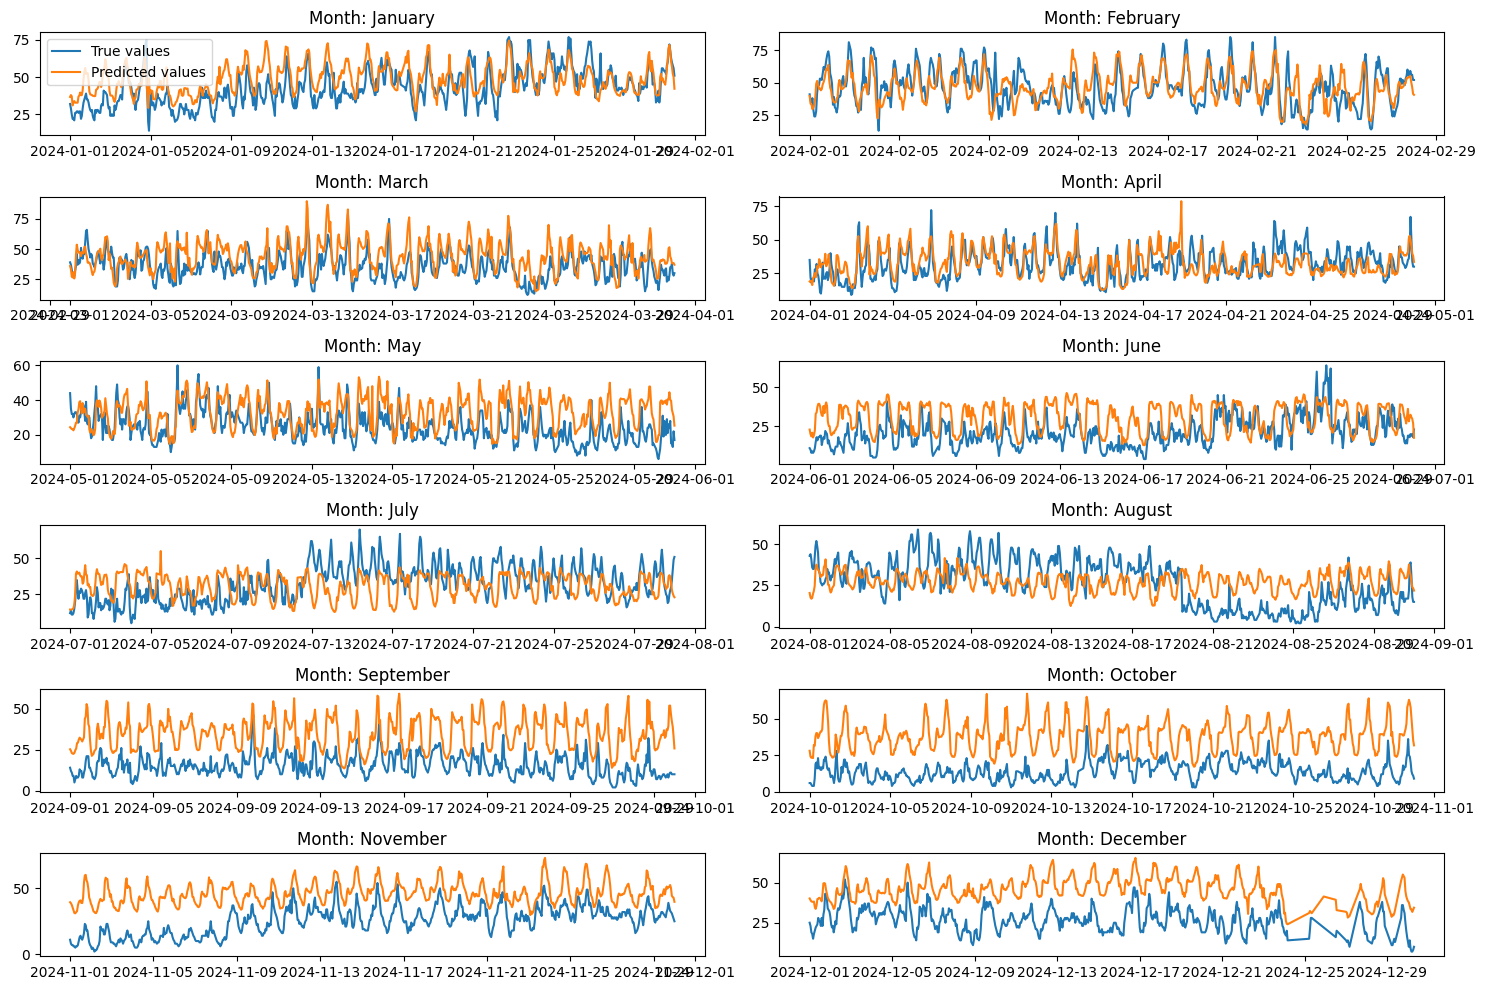

root_mean_squared_error: 16.2906735075959 (11.350533912857719)
r2_score: -0.3199244116491309 (0.3177199276828845)
mean_absolute_error: 13.648944470313774 (9.160393641565589)
huber: 2.709852695465088 (1.8121734857559204)


In [12]:
plt.figure(figsize=(15, 10))

for month in range(1, 13):
    start = datetime(2024, month, 1)
    end = datetime(2024, month, 28 if month == 2 else 30 if month in [4, 6, 9, 11] else 31)
    
    plt.subplot(6, 2, month)
    plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index >= start) & (test_sets[station][agent]['y'].index <= end)], label='True values')
    plt.plot(ffnn_pred_df[(ffnn_pred_df.index >= start) & (ffnn_pred_df.index <= end)], label='Predicted values')
    plt.title(f'Month: {start.strftime("%B")}')
    if month==1:plt.legend()

plt.tight_layout()
plt.show()

ffnn_scores={}
for m in metrics:
    a=test_sets[station][agent]['y']
    ffnn_score = m(a,ffnn_pred_df)
    ffnn_score_half = m(a[(a.index>=datetime(2024,1,1))&(a.index<=datetime(2024,5,31))],ffnn_pred_df[(ffnn_pred_df.index>=datetime(2024,1,1))&(ffnn_pred_df.index<=datetime(2024,5,31))])
    print(f'{m.__name__}: {ffnn_score} ({ffnn_score_half})')
    ffnn_scores[m.__name__] = ffnn_score

#### **Conv1d**

In [14]:
def build_conv_model(time_steps, n_features, optimizer='adam', loss='mean_absolute_error'):
    model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(time_steps, n_features)),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(1) 
    ])
    model.compile(optimizer=optimizer, loss=loss)
    return model
conv_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}
conv_train_params = {
    'epochs':10,
    'batch_size':64,
}
hour_models['Conv1D-5'] = (build_conv_model, conv_params, conv_train_params, True)

##### *Testing...*

In [ ]:
station = 'PORTA SAN FELICE'
agent = 'NO2'
ts = conv_params['time_steps']
conv_x_train = create_sequences(training_sets[station][agent]['x'], ts)
conv_y_train = training_sets[station][agent]['y'].iloc[ts:] 
conv_x_test = pd.concat([training_sets[station][agent]['x'].iloc[-ts:], test_sets[station][agent]['x']])
conv_x_test = create_sequences(conv_x_test, ts)
conv_y_test = test_sets[station][agent]['y']

tf.keras.backend.clear_session()  
set_random_seed(42) 
conv_model = build_conv_model(**conv_params)
conv_model.fit(conv_x_train, conv_y_train, **conv_train_params)
conv_pred = conv_model.predict(conv_x_test)
conv_pred_df = pd.DataFrame(conv_pred, index=conv_y_test.index)

Epoch 1/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 13.3919
Epoch 2/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.9552
Epoch 3/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.4840
Epoch 4/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.2019
Epoch 5/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.0733
Epoch 6/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.9586
Epoch 7/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.9156
Epoch 8/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.7557
Epoch 9/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.6483
Epoch 10/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.5632
Epoch 11/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.5380
Epoch 12/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.4311
Epoch 13/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.2881
Epoch 14/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.1757
Epoch 15/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - l

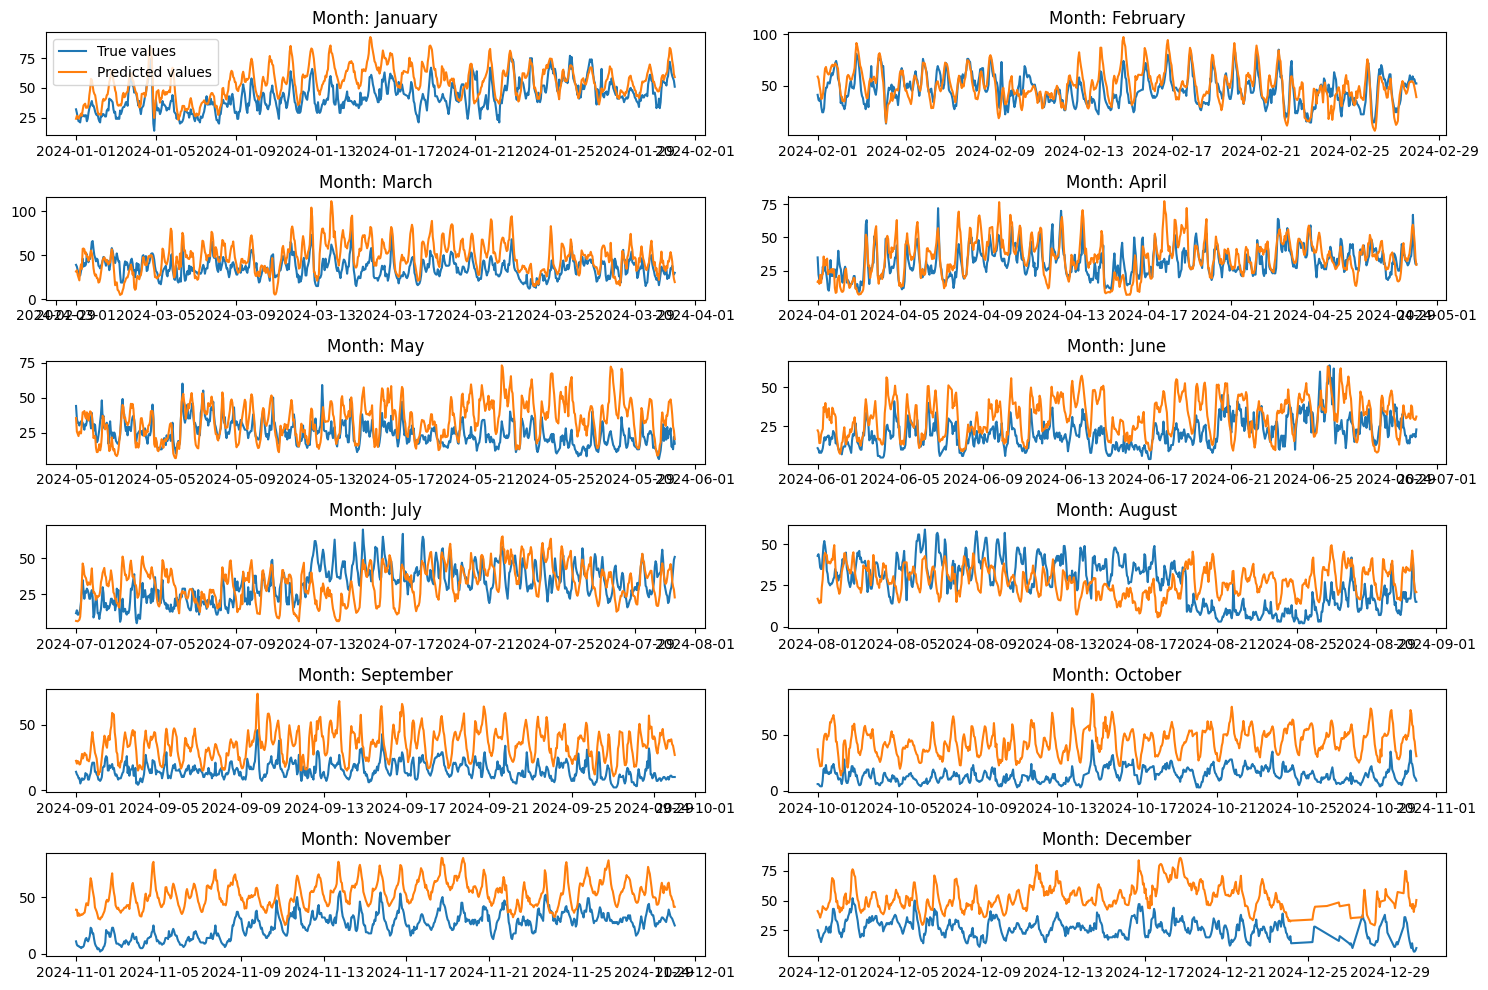

root_mean_squared_error: 19.881771191238045 (14.41317421499315)
r2_score: -0.965966943616237 (-0.10001385068796753)
mean_absolute_error: 16.452521080549488 (11.416257208681715)
huber: 3.2705605030059814 (2.263336420059204)


In [ ]:
plt.figure(figsize=(15, 10))

for month in range(1, 13):
    start = datetime(2024, month, 1)
    end = datetime(2024, month, 28 if month == 2 else 30 if month in [4, 6, 9, 11] else 31)
    
    plt.subplot(6, 2, month)
    plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index >= start) & (test_sets[station][agent]['y'].index <= end)], label='True values')
    plt.plot(conv_pred_df[(conv_pred_df.index >= start) & (conv_pred_df.index <= end)], label='Predicted values')
    plt.title(f'Month: {start.strftime("%B")}')
    if month==1:plt.legend()

plt.tight_layout()
plt.show()

ffnn_scores={}
for m in metrics:
    a=test_sets[station][agent]['y']
    ffnn_score = m(a,conv_pred_df)
    ffnn_score_half = m(a[(a.index>=datetime(2024,1,1))&(a.index<=datetime(2024,5,31))],conv_pred_df[(conv_pred_df.index>=datetime(2024,1,1))&(conv_pred_df.index<=datetime(2024,5,31))])
    print(f'{m.__name__}: {ffnn_score} ({ffnn_score_half})')
    ffnn_scores[m.__name__] = ffnn_score

#### **XGBoost**

In [149]:
xgbr_params = {
    'objective': "reg:squarederror",
    'n_estimators': 180,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9,
    'random_state': RANDOM_STATE,
}

hour_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

##### *Testing...*

In [160]:
agent = 'PORTA SAN FELICE'
agent = 'O3'

xgbr_model = xgb.XGBRegressor(**xgbr_params)
xgbr_model.fit(training_sets[station][agent]['x'], training_sets[station][agent]['y'])
xgbr_pred = xgbr_model.predict(test_sets[station][agent]['x'])
xgbr_pred_df = pd.DataFrame(xgbr_pred, index=test_sets[station][agent]['y'].index)

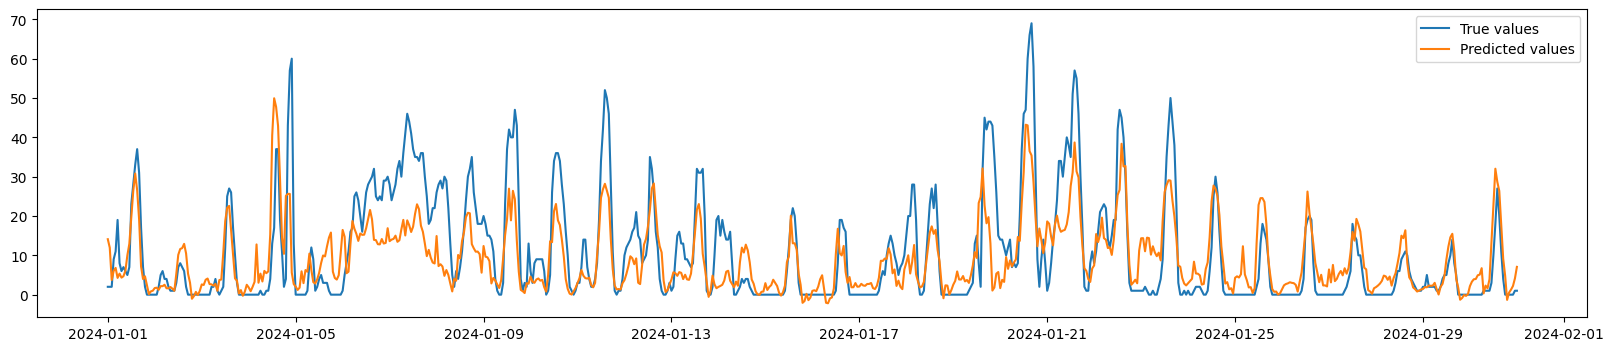

root_mean_squared_error: 13.877034469701544
r2_score: 0.8504408475828759
mean_absolute_error: 10.44955231401659
huber: 2.0700161457061768


In [161]:
start = datetime(2024,1,1)
end = datetime(2024,1,31)

plt.figure(figsize=figsize)
plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index>=start)&(test_sets[station][agent]['y'].index<=end)], label='True values')
plt.plot(xgbr_pred_df[(xgbr_pred_df.index>=start)&(xgbr_pred_df.index<=end)], label='Predicted values')
plt.legend()
plt.show()

xgbr_scores={}
for m in metrics:
    xgbr_score = m(test_sets[station][agent]['y'],xgbr_pred_df)
    print(f'{m.__name__}: {xgbr_score}')
    xgbr_scores[m.__name__] = xgbr_score

<BarContainer object of 24 artists>

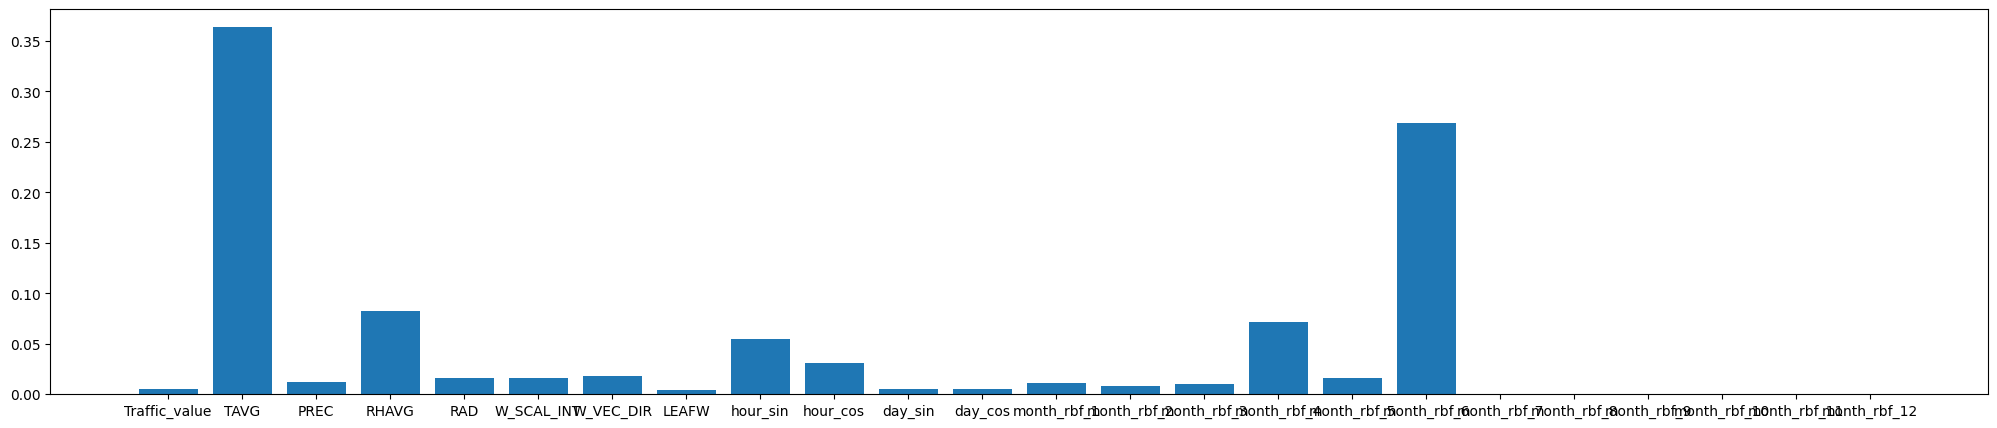

In [162]:
xgbr_feat = pd.Series(index=training_sets[station][agent]['x'].columns, data=xgbr_model.feature_importances_)
plt.figure(figsize=(25,5))
plt.bar(xgbr_feat.index,xgbr_feat)

#### **Test comparisons**

Assuming that the predictions are on the same station and agent.

NameError: name 'ffnn_pred_df' is not defined

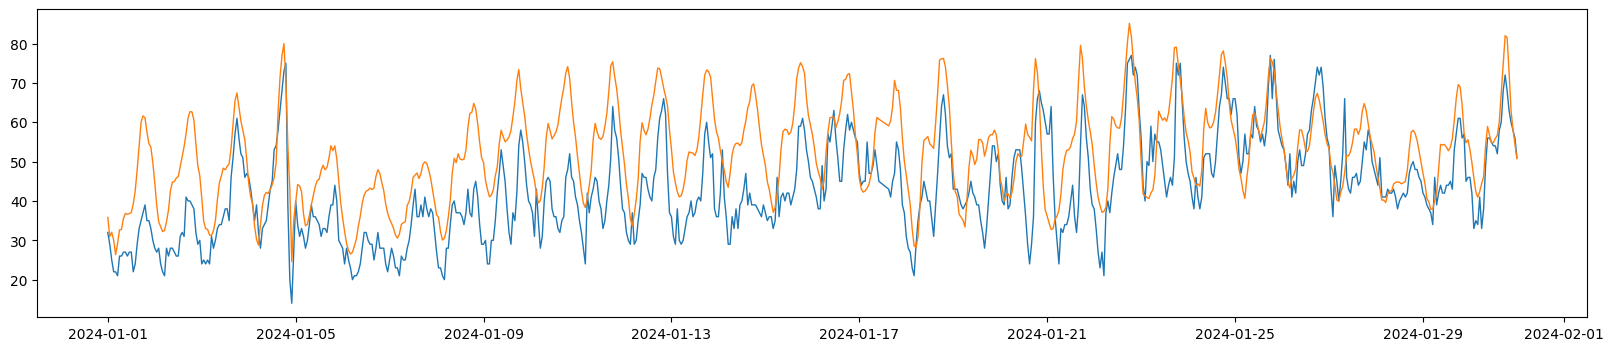

In [76]:
start = datetime(2024,1,1)
end = datetime(2024,1,31)

plt.figure(figsize=figsize)
plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index>=start)&(test_sets[station][agent]['y'].index<=end)], label='True values', linewidth=1)
plt.plot(lstm_pred_df[(lstm_pred_df.index>=start)&(lstm_pred_df.index<=end)], label='LSTM', linewidth=1)
plt.plot(ffnn_pred_df[(ffnn_pred_df.index>=start)&(ffnn_pred_df.index<=end)], label='ffnn values', linewidth=1)
plt.plot(xgbr_pred_df[(xgbr_pred_df.index>=start)&(xgbr_pred_df.index<=end)], label='xgb values', linewidth=1)
plt.plot(rfr_pred_df[(rfr_pred_df.index>=start)&(rfr_pred_df.index<=end)], label='rf values', linewidth=1)
# plt.xlim(test_sets[station][agent]['y'].index[0],test_sets[station][agent]['y'].index[-1])
plt.legend()
plt.show()

for m in metrics:
    name = m.__name__
    print(f'{name}:')
    print(f' - LSTM: {lstm_scores[name]}')
    print(f' - FFNN: {ffnn_scores[name]}')
    print(f' - XGB: {xgbr_scores[name]}')
    print(f' - RF: {rfr_scores[name]}')

ziocane ffnn ha gli errori più bassi di tutti ma fa merda

## **Daily agents**

In [6]:
daily_models = {} # contains tuples: (ModelClass, model_params:dict, training_params:dict, sequences:bool|dict)

**NOTE:** For now, I simply copied the one above

#### **Random Forest Regressor**

In [10]:
rfr_params = {
    'n_estimators':100,
    'max_depth':10
}

daily_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

#### **XGBoost Regressor**

In [84]:
xgbr_params = {
'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 70, 'subsample': 0.8, 
    'random_state': RANDOM_STATE,
}

daily_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

##### *Testing...*

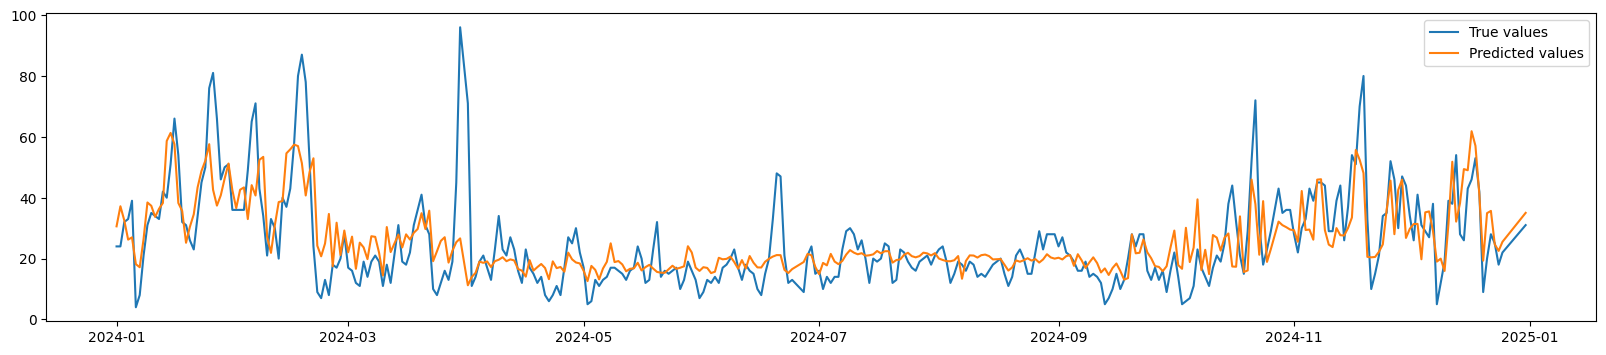

root_mean_squared_error: 10.877243596813964
r2_score: 0.5004098294502056
mean_absolute_error: 7.433011355025045
huber: 1.466736912727356


In [215]:
station = 'PORTA SAN FELICE'
agent = 'PM10'

xgbr_model = xgb.XGBRegressor(**xgbr_params)
xgbr_model.fit(training_sets[station][agent]['x'], training_sets[station][agent]['y'])
xgbr_pred = xgbr_model.predict(test_sets[station][agent]['x'])
xgbr_pred_df = pd.DataFrame(xgbr_pred, index=test_sets[station][agent]['y'].index)
start = datetime(2024,1,1)
end = datetime(2024,12,31)

plt.figure(figsize=figsize)
plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index>=start)&(test_sets[station][agent]['y'].index<=end)], label='True values')
plt.plot(xgbr_pred_df[(xgbr_pred_df.index>=start)&(xgbr_pred_df.index<=end)], label='Predicted values')
plt.legend()
plt.show()

xgbr_scores={}
for m in metrics:
    xgbr_score = m(test_sets[station][agent]['y'],xgbr_pred_df)
    print(f'{m.__name__}: {xgbr_score}')
    xgbr_scores[m.__name__] = xgbr_score

<BarContainer object of 30 artists>

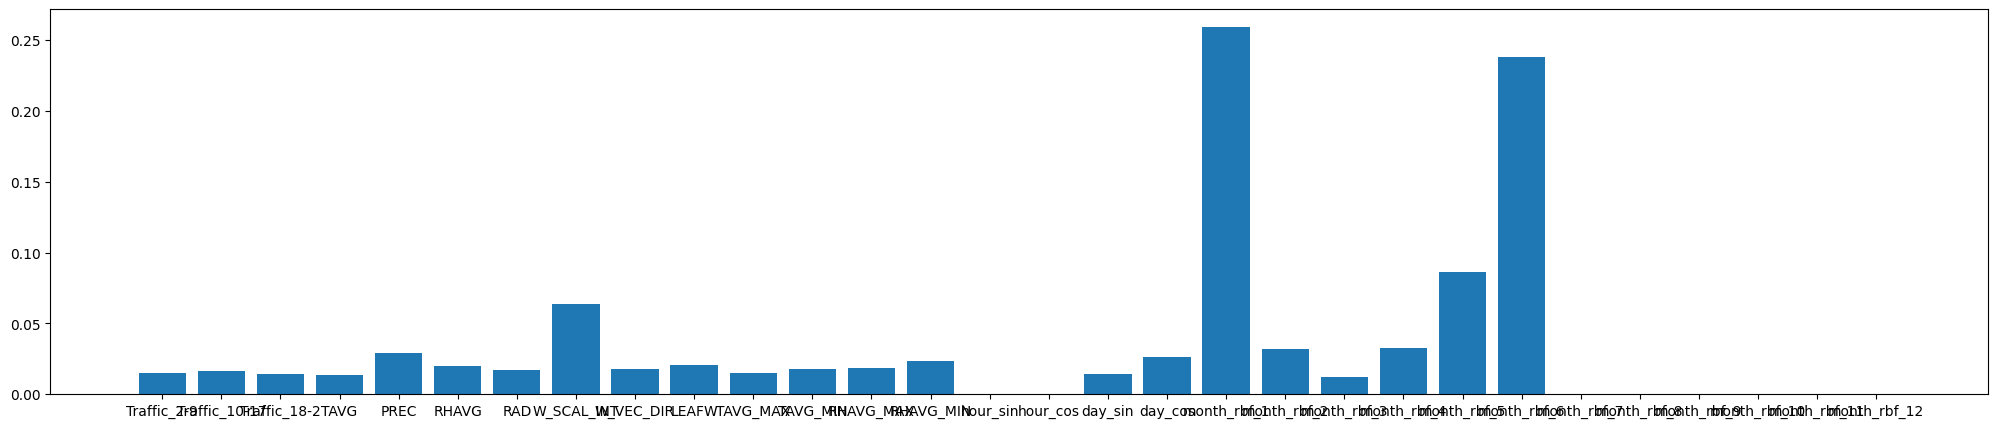

In [96]:
xgbr_feat = pd.Series(index=training_sets[station][agent]['x'].columns, data=xgbr_model.feature_importances_)
plt.figure(figsize=(25,5))
plt.bar(xgbr_feat.index,xgbr_feat)

#### **FFNN**

In [7]:
def build_ffnn_model(n_features, optimizer='adam', loss='mean_absolute_error', batch_norm=False):
    model = None
    if batch_norm:
        model = Sequential([
            Dense(1024, activation='relu', input_shape=(n_features,)),
            BatchNormalization(),
            Dropout(0.3),
            Dense(512*1, activation='relu'), 
            BatchNormalization(),
            Dropout(0.2),
            Dense(256*1, activation='relu'),  
            BatchNormalization(),
            Dropout(0.2),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dense(1)
        ])
    else:
        model = Sequential([
            Dense(1024*1, activation='relu', input_shape=(n_features,)),
            Dropout(0.2),
            Dense(512*1, activation='relu'), 
            Dropout(0.2),
            Dense(256*1, activation='relu'),  
            Dropout(0.2),
            Dense(128*1, activation='relu'),  
            Dropout(0.2),
            Dense(64*1, activation='relu'),  
            Dense(1)
        ])    

    model.compile(optimizer=optimizer, loss=loss)

    return model

ffnn_params = {
    'n_features': n_daily_features,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}


ffnn_train_params = {
    'epochs':20,
    'batch_size':32,
}

daily_models['Feed Forward NN'] = (build_ffnn_model, ffnn_params, ffnn_train_params, False)

In [9]:
ffnn_params_BN = {
    'n_features': n_daily_features,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error',
    'batch_norm':True
}

daily_models['Feed Forward NN-BN'] = (build_ffnn_model, ffnn_params_BN, ffnn_train_params, False)

##### *Testing...*

In [13]:
station = 'PORTA SAN FELICE'
agent = 'PM10'

tf.keras.backend.clear_session()  
set_random_seed(42) 
ffnn_model = build_ffnn_model(**ffnn_params)
ffnn_model.fit(
    training_sets[station][agent]['x'], 
    training_sets[station][agent]['y'], 
    **ffnn_train_params
    )
ffnn_pred = ffnn_model.predict(test_sets[station][agent]['x'])
ffnn_pred_df = pd.DataFrame(ffnn_pred, index=test_sets[station][agent]['y'].index)

Epoch 1/20
56/56 [==============================] - 1s 8ms/step - loss: 10.5166
Epoch 2/20
56/56 [==============================] - 0s 6ms/step - loss: 7.8112
Epoch 3/20
56/56 [==============================] - 0s 5ms/step - loss: 7.4324
Epoch 4/20
56/56 [==============================] - 0s 5ms/step - loss: 7.2739
Epoch 5/20
56/56 [==============================] - 0s 5ms/step - loss: 7.1448
Epoch 6/20
56/56 [==============================] - 0s 5ms/step - loss: 7.0733
Epoch 7/20
56/56 [==============================] - 0s 5ms/step - loss: 7.1189
Epoch 8/20
56/56 [==============================] - 0s 6ms/step - loss: 6.7976
Epoch 9/20
56/56 [==============================] - 0s 6ms/step - loss: 6.7300
Epoch 10/20
56/56 [==============================] - 0s 6ms/step - loss: 6.7892
Epoch 11/20
56/56 [==============================] - 0s 6ms/step - loss: 6.7961
Epoch 12/20
56/56 [==============================] - 0s 6ms/step - loss: 6.5419
Epoch 13/20
56/56 [=============================

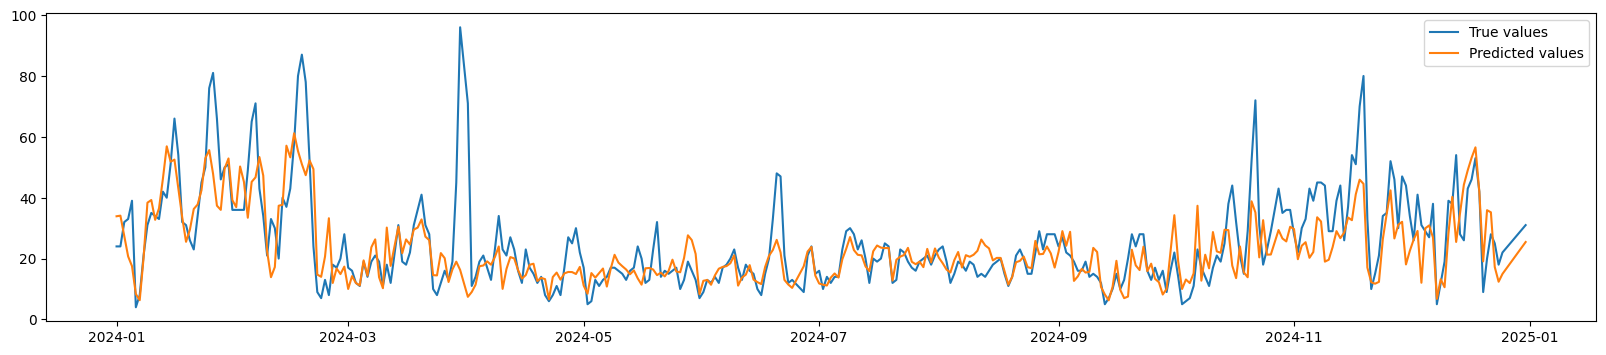

root_mean_squared_error: 10.9906479761611
r2_score: 0.48993823260576597
mean_absolute_error: 6.997144942872979
huber: 1.3796519041061401


In [9]:
start = datetime(2024,1,1)
end = datetime(2024,12,31)

plt.figure(figsize=figsize)
plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index>=start)&(test_sets[station][agent]['y'].index<=end)], label='True values')
plt.plot(ffnn_pred_df[(ffnn_pred_df.index>=start)&(ffnn_pred_df.index<=end)], label='Predicted values')
plt.legend()
plt.show()

ffnn_scores={}
for m in metrics:
    ffnn_score = m(test_sets[station][agent]['y'],ffnn_pred_df)
    print(f'{m.__name__}: {ffnn_score}')
    ffnn_scores[m.__name__] = ffnn_score

#### **LSTM**

In order to use LSTM, we should have sequences/time steps. For the other models, be aggregated the hourly data into a single day, but we could try to use 24 hours to predict the daily value.

## **Agents Evaluations**

### Hour Models

In [14]:
hour_results = train_models(
    hour_models,training_sets,test_sets,metrics,
    to_execute={
        'agents':['NO2','O3','C6H6'],
        'stations':'all',
        'models':'all',
    },
    ignore={
        'stations':[],
        'agents':['PM10','PM2.5'],
        'models':[]
        },
    random_state=RANDOM_STATE,
    v=1
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['NO2', 'O3', 'C6H6']
models: ['LSTM-masked', 'LSTM', 'LSTM-old', 'LSTM-old-masked', 'LSTM_2', 'LSTM_2-masked']
Agent NO2
> LSTM-masked model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> LSTM model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> LSTM-old model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> LSTM-old-masked model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> LSTM_2 model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> LSTM_2-masked model:
 >> Training station GIARDINI MARGHERITA...
 >> Training 

In [16]:
hour_extracted_data = extract_data(hour_results)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(hour_extracted_data.loc[hour_extracted_data.groupby(by=['Station','Agent'])['root_mean_squared_error'].idxmin()])
    display(hour_extracted_data.sort_values(by=['Station','Agent','root_mean_squared_error']))

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
0,GIARDINI MARGHERITA,NO2,LSTM-masked,6.784603,0.588013,4.586678,0.897590
10,GIARDINI MARGHERITA,O3,LSTM_2,12.603757,0.875465,9.488341,1.877781
23,PORTA SAN FELICE,C6H6,LSTM_2-masked,0.412054,0.657019,0.264692,0.037230
12,PORTA SAN FELICE,NO2,LSTM-masked,18.497270,-0.701713,15.480646,3.076169
25,VIA CHIARINI,NO2,LSTM,6.775676,0.581930,5.152271,1.010630
30,VIA CHIARINI,O3,LSTM-masked,12.939649,0.869964,9.694309,1.918977


,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
0,GIARDINI MARGHERITA,NO2,LSTM-masked,6.784603,0.588013,4.586678,0.897590
2,GIARDINI MARGHERITA,NO2,LSTM-old,6.795247,0.586719,4.633741,0.907024
5,GIARDINI MARGHERITA,NO2,LSTM_2-masked,7.067549,0.552933,4.895375,0.959317
1,GIARDINI MARGHERITA,NO2,LSTM,7.115367,0.546863,4.860455,0.952378
3,GIARDINI MARGHERITA,NO2,LSTM-old-masked,7.192003,0.537049,4.910577,0.962360
4,GIARDINI MARGHERITA,NO2,LSTM_2,7.346109,0.516997,5.083519,0.996934
10,GIARDINI MARGHERITA,O3,LSTM_2,12.603757,0.875465,9.488341,1.877781
11,GIARDINI MARGHERITA,O3,LSTM_2-masked,12.828364,0.870987,9.632454,1.906620
7,GIARDINI MARGHERITA,O3,LSTM,13.174434,0.863933,9.823795,1.944943
6,GIARDINI MARGHERITA,O3,LSTM-masked,13.394470,0.859350,9.971862,1.974545


old complete results... do  not override

In [30]:
hour_extracted_data = extract_data(hour_results)
# hour_extracted_data.sort_values(by=[])
hour_extracted_data.loc[hour_extracted_data.groupby(by=['Station','Agent'])['root_mean_squared_error'].idxmin()]

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
17,GIARDINI MARGHERITA,NO2,LSTM,6.725825,0.595120,4.597018,0.899681
1,GIARDINI MARGHERITA,O3,LSTM-old,12.410668,0.879252,9.256034,1.831409
67,PORTA SAN FELICE,C6H6,Conv1D-5,0.404434,0.669587,0.258625,0.035957
34,PORTA SAN FELICE,CO,Conv1D-2,0.208691,0.567442,0.159813,0.017457
52,PORTA SAN FELICE,NO2,Conv1D-5,16.374771,-0.333587,13.510690,2.682191
102,VIA CHIARINI,NO2,Conv_res1D-3,6.400351,0.626964,4.881195,0.956431
88,VIA CHIARINI,O3,LSTM_2,12.797524,0.872805,9.610663,1.902263


In [33]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(hour_extracted_data.sort_values(by=['Station','Agent','root_mean_squared_error']))

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
17,GIARDINI MARGHERITA,NO2,LSTM,6.725825,0.595120,4.597018,0.899681
27,GIARDINI MARGHERITA,NO2,Conv_res1D-3,6.737407,0.593725,4.590713,0.898538
19,GIARDINI MARGHERITA,NO2,Conv1D-2,6.959523,0.566495,4.842446,0.948732
18,GIARDINI MARGHERITA,NO2,Conv1D,7.090805,0.549986,4.926297,0.965509
28,GIARDINI MARGHERITA,NO2,LSTM_2,7.134573,0.544414,5.023153,0.984847
23,GIARDINI MARGHERITA,NO2,Conv_res1D,7.229194,0.532249,4.931438,0.966590
26,GIARDINI MARGHERITA,NO2,Conv_res1D-2,7.244927,0.530211,5.033745,0.986976
24,GIARDINI MARGHERITA,NO2,Conv_res1D-1,7.297735,0.523337,5.136712,1.007573
21,GIARDINI MARGHERITA,NO2,Conv1D-4,7.426482,0.506371,5.234638,1.027122
15,GIARDINI MARGHERITA,NO2,Random Forest Regressor,7.435556,0.505163,5.517238,1.083616


##### **EXAMPLE:** how to eventually try new metrics

In [ ]:
from sklearn.metrics import mean_squared_error

metrics.append(mean_squared_error) # even if you append multiple times, the result is written on a dict so there are no duplicates. Anyways, be careful :)

In [ ]:
new_hour_results = update_metrics(hour_results, test_sets, metrics)
new_hour_extracted_data = extract_data(new_hour_results)
new_hour_extracted_data.sort_values(by=['Agent','Model','Station'])

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,mean_squared_error
1,GIARDINI MARGHERITA,NO2,XGB Regressor,7.693566,0.470227,5.591722,59.190959
3,VIA CHIARINI,NO2,XGB Regressor,8.510072,0.340508,6.351527,72.421325
0,GIARDINI MARGHERITA,O3,XGB Regressor,14.529542,0.834502,10.980940,211.107599
2,VIA CHIARINI,O3,XGB Regressor,14.504967,0.836600,10.876629,210.394056


### Daily Models

In [10]:
daily_results = train_models(
    daily_models, training_sets, test_sets, metrics,
    to_execute={
        'agents':['PM10','PM2.5'],
        'stations':'all',
        'models':'all',
        },
    ignore={
        'stations':[],
        'agents':[],
        'models':[]
        },
    v=1
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['PM10', 'PM2.5']
models: ['Feed Forward NN']
Agent PM10
> Feed Forward NN model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
Agent PM2.5
> Feed Forward NN model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...


In [16]:
# updated_daily_results = update_metrics(daily_results, test_sets, []) # an empty list simply wont add metrics
daily_extracted_data = extract_data(daily_results)
daily_extracted_data.loc[daily_extracted_data.groupby(by=['Station','Agent'])['root_mean_squared_error'].idxmin()]

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
1,GIARDINI MARGHERITA,PM10,Feed Forward NN-BN,10.472045,0.410287,7.047342,1.389783
4,GIARDINI MARGHERITA,PM2.5,Feed Forward NN,8.359619,0.484170,5.825541,1.145298
9,PORTA SAN FELICE,PM10,Feed Forward NN-BN,10.845932,0.503282,7.029507,1.386100
12,PORTA SAN FELICE,PM2.5,Feed Forward NN,7.394078,0.621348,4.880111,0.956188
16,VIA CHIARINI,PM10,Feed Forward NN,10.977390,0.366498,7.803226,1.540722


In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(daily_extracted_data.sort_values(by=['Station','Agent','root_mean_squared_error']))

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
1,GIARDINI MARGHERITA,PM10,Feed Forward NN-BN,10.472045,0.410287,7.047342,1.389783
0,GIARDINI MARGHERITA,PM10,Feed Forward NN,10.483455,0.409002,7.139633,1.408101
3,GIARDINI MARGHERITA,PM10,Feed Forward NN-huber-BN,10.888393,0.362463,7.377830,1.455682
2,GIARDINI MARGHERITA,PM10,Feed Forward NN-huber,13.174327,0.066672,8.760230,1.732170
4,GIARDINI MARGHERITA,PM2.5,Feed Forward NN,8.359619,0.484170,5.825541,1.145298
7,GIARDINI MARGHERITA,PM2.5,Feed Forward NN-huber-BN,8.629876,0.450279,5.886092,1.157427
5,GIARDINI MARGHERITA,PM2.5,Feed Forward NN-BN,8.710498,0.439960,5.942026,1.168576
6,GIARDINI MARGHERITA,PM2.5,Feed Forward NN-huber,12.239907,-0.105833,7.780451,1.536090
9,PORTA SAN FELICE,PM10,Feed Forward NN-BN,10.845932,0.503282,7.029507,1.386100
11,PORTA SAN FELICE,PM10,Feed Forward NN-huber-BN,10.856491,0.502314,7.176424,1.415543
